# COGS 108 - Final Project 

# Overview

With the data given I explored two types of socioeconomic factors and their relationships to the number of health code violations in an area: the percentage of non-white population and the income levels. This was done to determine the effects of these factors on the health inspection process. Through linear and multiple regression we tested these variables to and determined I was able to reject the null hypothesis and prove my hypothesis correct. However, my results may not be accurate due to there being existing multicollinearity.

# Name & GitHub

- Name: Nate Abdulmawla
- GitHub Username: nateabdul

# Research Question

What is the effect of socioeconomic factors of an area on the amount of health code violations found in a restaurant?

## Background and Prior Work

The relationship between the socioeconomic factors of an area and its general health is one that has been studied often. These studies have shown that socioeconomic status has shown to indirectly damage health through impacting the factors that do directly cause damage to health to the extent of reducing life expectancy by 2.1 years (1). Health inspections are an important process that most businesses must go through to maintain public health. Violations of many kinds are found often, common ones being issues regarding improper food temperatures, employee cleanliness, and pests (2).

When accounting for these we follow a path of questioning the relationship between the cleanliness of the businesses in an area and the income levels of the area. Looking at the most common types of violations in an area and how serious they are is an important step in this. This will give us a clearer view to see if there are any certain issues common to a certain area that can be improved on at a systemic level.

There may be other factors at hand to this. Institutionalized racism and classism is rampant throughout many fields, health departments included (3). This actively contributes to the cycle that enforces poorer health conditions in lower income areas. Through this project I wish to see if its possible to observe this in a concerete manner.


References:

(1) https://www.thelancet.com/journals/lancet/article/PIIS0140-6736(16)32380-7/fulltext

(2) https://www.foodsafetymagazine.com/enewsletter/challenges-of-health-department-food-safety-inspections/

(3) https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2565803/

# Hypothesis


I hypothesize that restaurants in lower income areas will have an increased amount of health code violations compared to those of higher income areas. Similarly, I hypothesize that when accounting for non-white populations, they will also have an increased amount of health code violations. This could be due to various reasons, ranging from a lack of education to not having enough resources to be able to maintain ideal standards.

# Dataset(s)

- Dataset Name: inspections.csv
- Link to the dataset: inspections.csv
- Number of observations: 18466 observations
This dataset contains the information of the restaurants and the information of the inspector. This dataset will be used for the zip codes.

- Dataset Name: violations.csv
- Link to the dataset: violations.csv
- Number of observations: 189802 observations
This dataset contains more detailed information regarding the inspection of the restaurants 

- Dataset Name: zipcodes.csv
- Link to the dataset: zipcodes.csv
- Number of observations: 38 observations
This dataset contains the demographics of each zip code. I will be using the median_household_income_dollars column as this best describes the economic health of the area and the percent_nonwhite column to account. 

I plan to initially merge the inspections and violations datasheet by "hsisid" which will give the combined dataset a "zip" column that can be subsequently merged with the "zip" column in the zipcodes datasheet.

# Setup

In [3]:
#imports
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_context('talk')

import warnings
warnings.filterwarnings('ignore')

import patsy
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest

# Data Cleaning

Describe your data cleaning steps here.

In [75]:
#import datasets
df_inspections = pd.read_csv('inspections.csv')
df_restaurants = pd.read_csv('restaurants.csv')
df_violations = pd.read_csv('violations.csv')
df_zipcodes = pd.read_csv('zipcodes.csv')

In [76]:
#drop unneeded columns
df_inspections = df_inspections[['hsisid', 'zip']]
df_violations = df_violations[['hsisid', 'category', 'shortdesc']]
df_zipcodes = df_zipcodes[['zip', 'median_household_income_dollars', 'percent_nonwhite']]

In [77]:
#consolidate, organize, and standardize datasets
df_final = pd.merge(df_inspections, df_violations, on = 'hsisid')

df_final = df_final.drop_duplicates(subset = 'hsisid', keep = 'last')

df_final = df_final.drop(labels = ['hsisid'], axis = 1)
df_final = df_final.reset_index(drop = True)


df_final = pd.merge(df_final, df_zipcodes, on = 'zip')
df_final = df_final[['zip', 'median_household_income_dollars', 'percent_nonwhite', 'category', 'shortdesc']]

In [80]:
#obtaining number of health code violations per zip code
df_final['violationcount'] = df_final.groupby(['zip']).transform(len)

In [81]:
#our end result
df_final

,zip,median_household_income_dollars,percent_nonwhite,category,shortdesc,violationcount
0,27610,45209,72.7,Chemical,"Toxic substances properly identified, stored, ...",140
1,27610,45209,72.7,Utensils and Equipment,Non-food contact surfaces clean,140
2,27610,45209,72.7,Approved Source,Food obtained from approved source,140
3,27610,45209,72.7,Chemical,"Toxic substances properly identified, stored, ...",140
4,27610,45209,72.7,Chemical,"Toxic substances properly identified, stored, ...",140
...,...,...,...,...,...,...
2994,27596,59712,18.9,Utensils and Equipment,"Equipment, food & non-food-contact surfaces ap...",3
2995,27596,59712,18.9,Utensils and Equipment,Non-food contact surfaces clean,3
2996,27596,59712,18.9,Utensils and Equipment,Non-food contact surfaces clean,3
2997,27501,51121,17.9,Chemical,"Toxic substances properly identified, stored, ...",1


# Data Analysis & Results

We begin by trying to get a better understanding of the economic factors by looking at the average household income by zip code.

Text(0.5, 1.0, 'median household income per zip code')

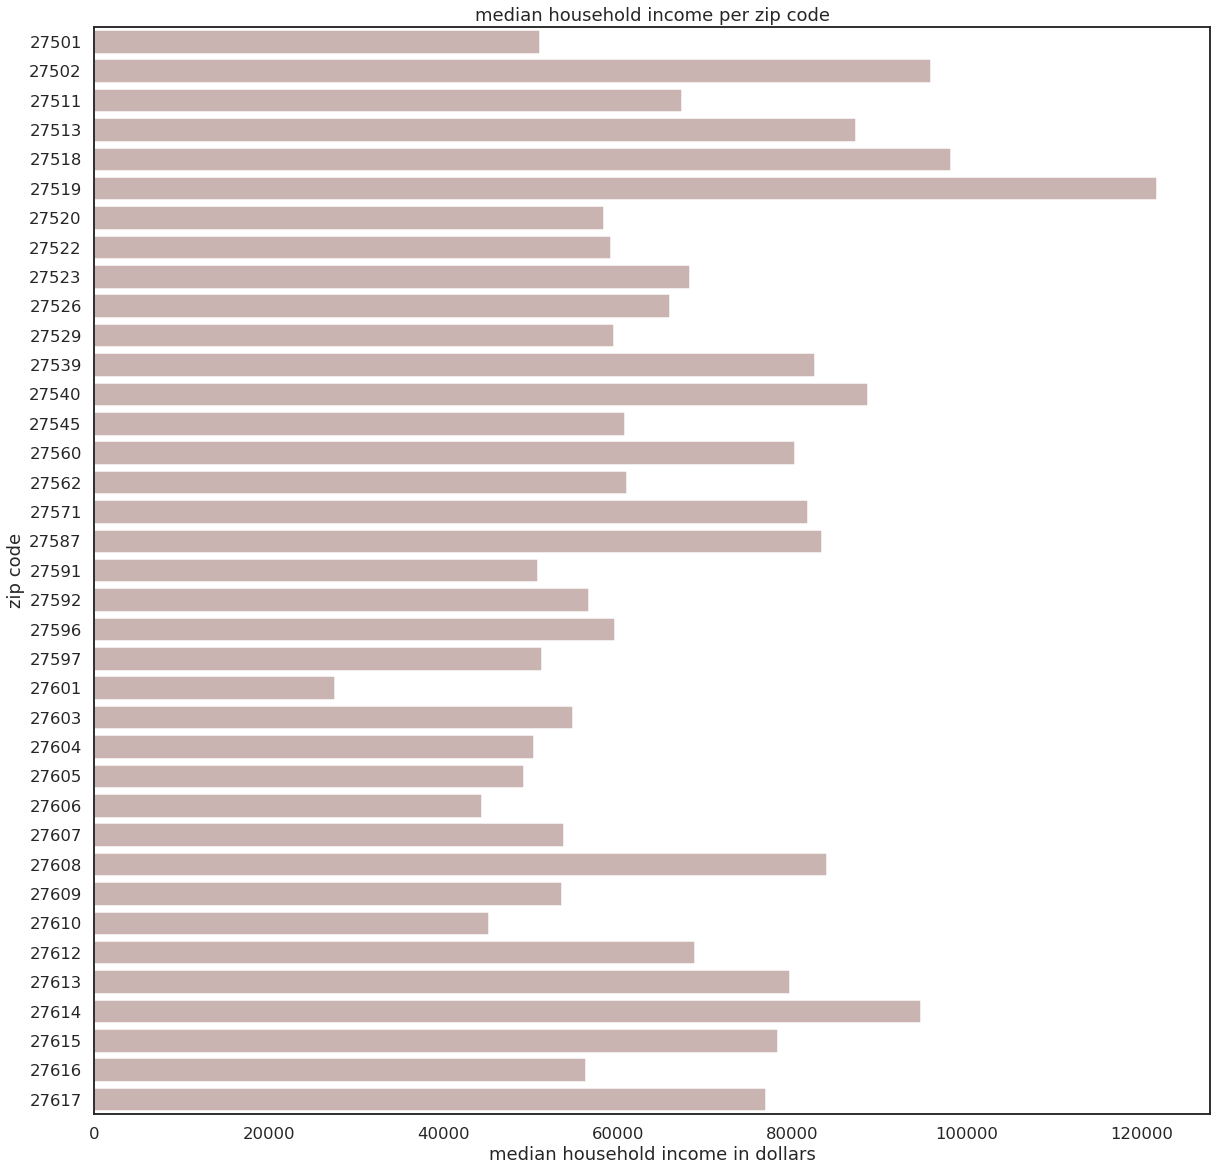

In [30]:
#less is more, simplify graphs
sns.set_style('white')

zipincome = plt.subplots(figsize = (20, 20))
zipincome = sns.barplot(data = df_final, orient= 'h', x = 'median_household_income_dollars', y = 'zip', color = '#cdb1ad')

zipincome.set_xlabel('median household income in dollars')
zipincome.set_ylabel('zip code')
zipincome.set_title('median household income per zip code')

Following this we must account for the social factors by looking at the percent of nonwhite populations within each of the zip codes.

Text(0.5, 1.0, 'percentage of non-white population per zip code')

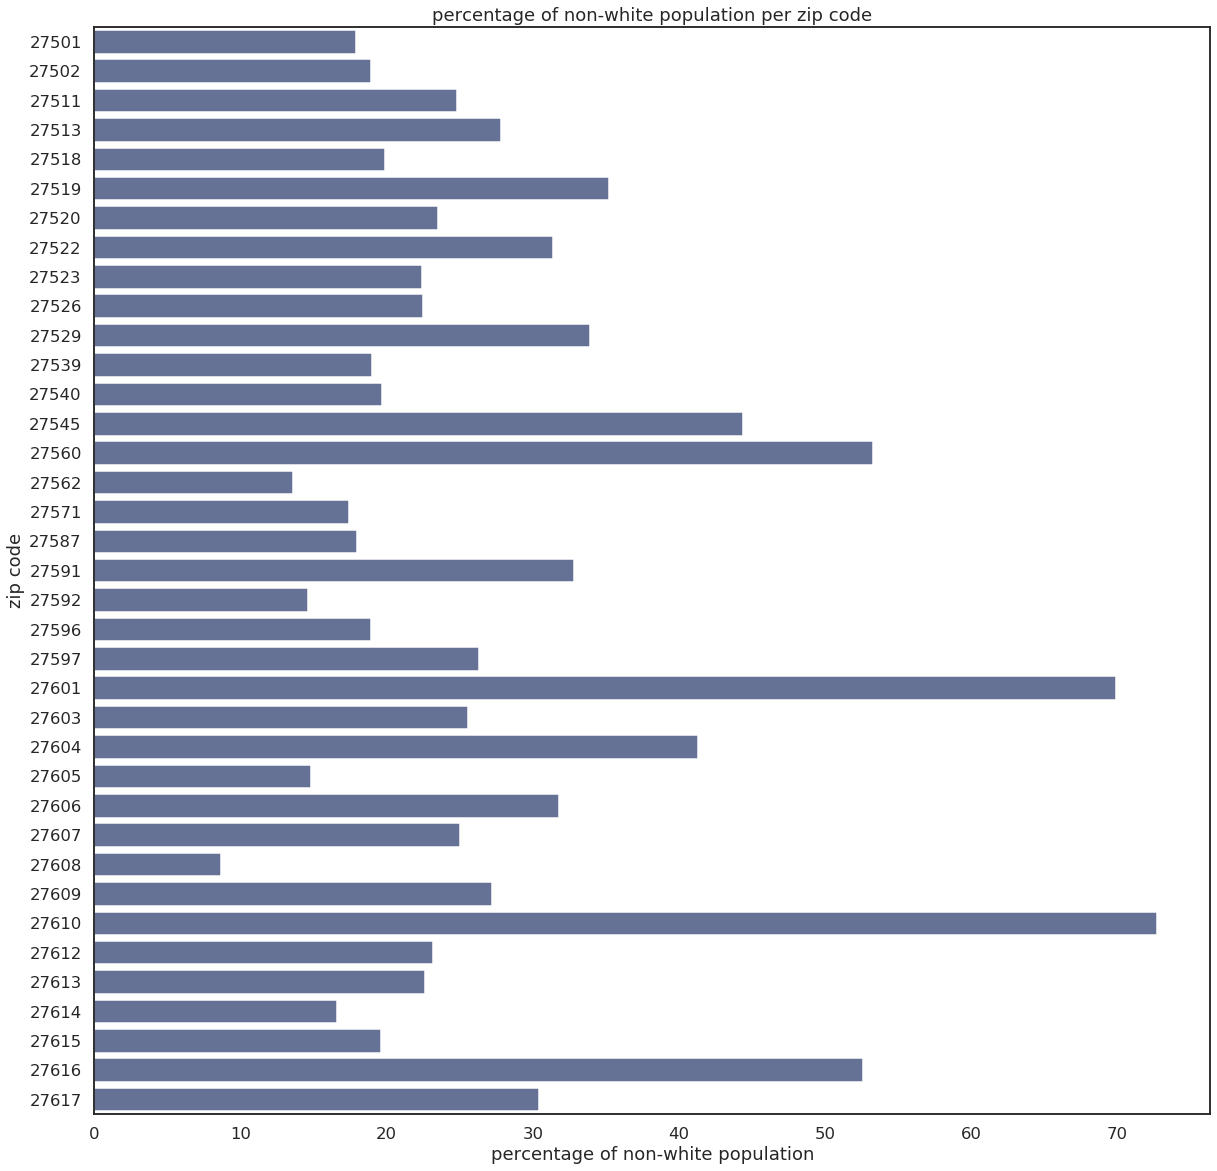

In [31]:
zip_nonwhite = plt.subplots(figsize = (20, 20))
zip_nonwhite = sns.barplot(data = df_final, orient= 'h', x = 'percent_nonwhite', y = 'zip', color = '#5d6e9e')

zip_nonwhite.set_xlabel('percentage of non-white population')
zip_nonwhite.set_ylabel('zip code')
zip_nonwhite.set_title('percentage of non-white population per zip code')

With these two plots we can begin to look at the amount of health code violations found within restaurants in each zip code.

Text(0.5, 1.0, 'amount of health code violations per zip code')

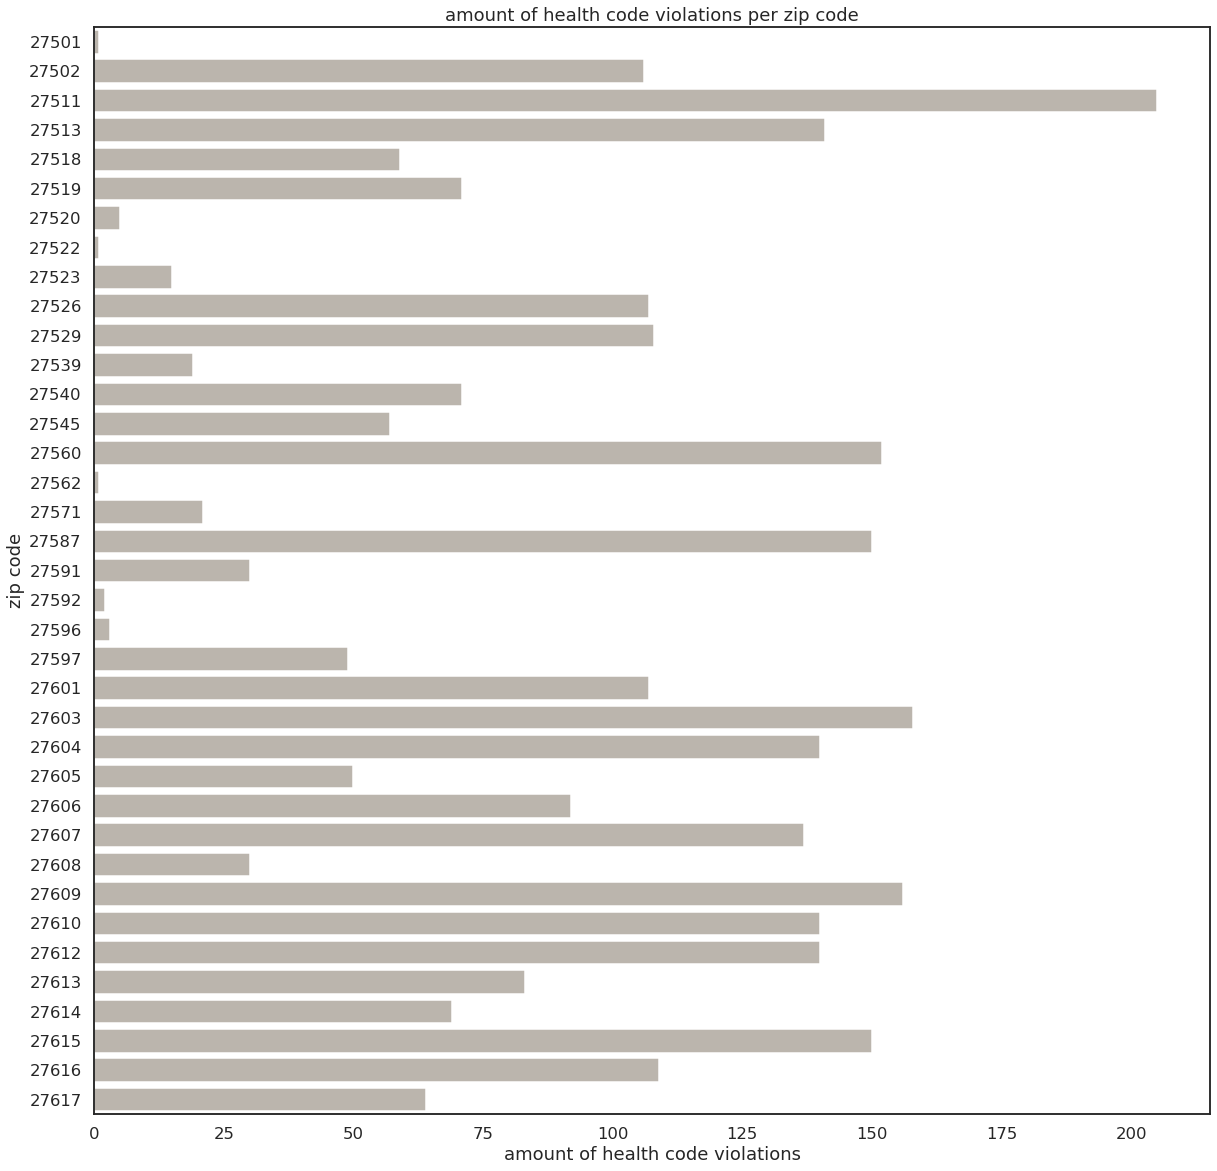

In [32]:
zip_violation = plt.subplots(figsize = (20, 20))
zip_violation = sns.countplot(data = df_final, y = 'zip', color='#bdb6ab')

zip_violation.set_xlabel('amount of health code violations')
zip_violation.set_ylabel('zip code')
zip_violation.set_title('amount of health code violations per zip code')

When looking at this plot of the amount of health violations per zip code we can see no immediate relationship between the amount of violations and the median household income. There also seems to be no immediate relationship when looking at the percentage of non-white population.

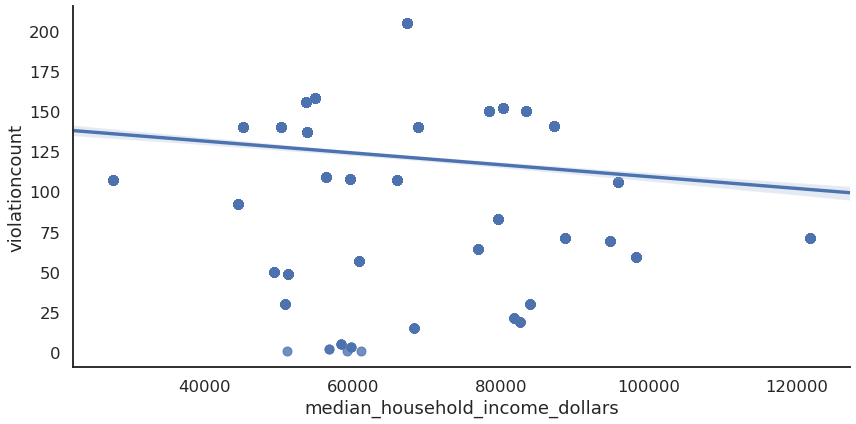

In [84]:
lm_1 = sns.lmplot(data = df_final, x = 'median_household_income_dollars', y = 'violationcount', height = 6, aspect = 2)

This linear regression plot points to there being almost no relationship between the median household income and the amount of health code violations in an area.

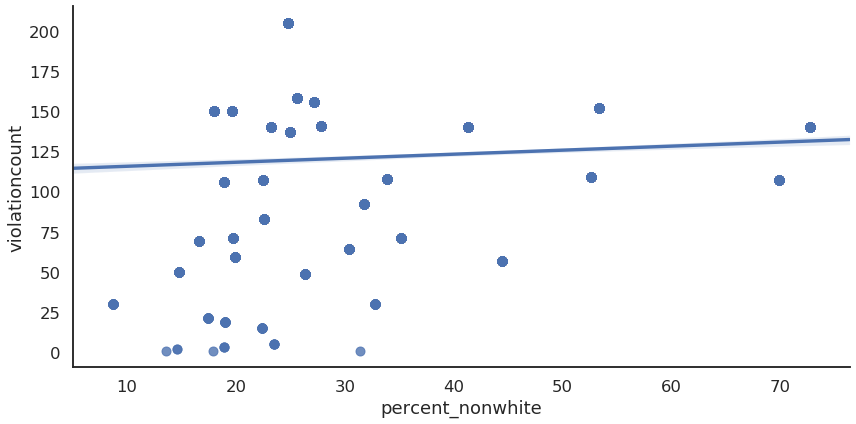

In [67]:
lm_2 = sns.lmplot(data = df_final, x = 'percent_nonwhite', y = 'violationcount', height = 6, aspect = 2)

This plot also points to there being almost no relationship between the amount of nonwhite citizens in an area and the amount of violations in an area. 

In [99]:
outcome_1, predictors_1 = patsy.dmatrices('violationcount ~ median_household_income_dollars', df_final)
mod_1 = sm.OLS(outcome_1, predictors_1)
res_1 = mod_1.fit()
print(res_1.summary())

                            OLS Regression Results                            
Dep. Variable:         violationcount   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     77.88
Date:                Wed, 10 Jun 2020   Prob (F-statistic):           1.82e-18
Time:                        16:48:51   Log-Likelihood:                -15554.
No. Observations:                2999   AIC:                         3.111e+04
Df Residuals:                    2997   BIC:                         3.112e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

In [98]:
outcome_2, predictors_2 = patsy.dmatrices('violationcount ~ percent_nonwhite', df_final)
mod_2 = sm.OLS(outcome_2, predictors_2)
res_2 = mod_2.fit()
print(res_2.summary())

                            OLS Regression Results                            
Dep. Variable:         violationcount   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     24.07
Date:                Wed, 10 Jun 2020   Prob (F-statistic):           9.78e-07
Time:                        16:48:41   Log-Likelihood:                -15581.
No. Observations:                2999   AIC:                         3.117e+04
Df Residuals:                    2997   BIC:                         3.118e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          113.2121      1.805  

In [100]:
outcome_3, predictors_3 = patsy.dmatrices('violationcount ~ median_household_income_dollars + percent_nonwhite', df_final)
mod_3 = sm.OLS(outcome_3, predictors_3)
res_3 = mod_3.fit()
print(res_3.summary())

                            OLS Regression Results                            
Dep. Variable:         violationcount   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     39.19
Date:                Wed, 10 Jun 2020   Prob (F-statistic):           1.58e-17
Time:                        16:49:17   Log-Likelihood:                -15554.
No. Observations:                2999   AIC:                         3.111e+04
Df Residuals:                    2996   BIC:                         3.113e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

We ran three different regressions, two linear regressions and one multiple regression. One with the variable for median household income, the second with the nonwhite population percentage. The final multiple regression was done with both of these variables

Within the three tests we found both linear regressions to be significant: P < 0.05. In the multiple regression we found the nonwhite population to not be statistically significant.

These results show that we are able to reject the null hypothesis. This supports my hypothesis that lower income areas recieve more health code violations, even well when accounting for non-white populations. However, it is important to note that some of these these results may not be accurate as the test indicates that there is a strong multicollinearity. 

# Ethics & Privacy

As the datasets were made publicly available and could be obtained through the county website there should be no concerns regarding privacy. The datasets themselves did have some data that was slightly concerning such as phone numbers and names. These were removed in the process of consolidating and organizing the datasets, keeping only general data that would not have any privacy concerns.

While there shouldn't be any biases regarding those who composed the datasets, the results obtained brought to light some potential concerns regarding bias within the inspectors themselves. There may be an inherent class or racial bias in the system. However, this isn't something that can be concluded by these results. 

# Conclusion & Discussion

The purpose of the project was to look at effects of socioeconomic factors on the health inspection process and its results. Using  data obtained from Wake County, North Carolina we found that there may be a high correlation in the percentage of nonwhites in an area and the amount of health code violations, as well as with the median household income. 

There could be a variety of reasons for this that is not visible within the dataset, or would require deeper analysis to find. There may be biases within individual inspectors or within the system as a whole. This may also be due to a lack of resources or education on proper safety. 

These reasons that are unable to be accounted for using the dataset are also large limitations within the project. While this project points toward a certain result, it only touches the surface level of the issue. This conclusion cannot be fully argued with confidence without controlling for myriad of factors.